In [11]:
# ============================================================
# CELL 1 (方案B): Thesis slicing split（每个主变量取值=一个 slice）
# 注意：要真正做 thesis，多模型训练，Cell2 的循环也要改
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("clean_ul_with_conditions2.csv")

target_col = "pm_power"

# thesis 切片：这里的 FEATURE_SETS 不是“特征集合”，而是“用哪个变量切片”
EXPERIMENTS = {
    "gain": "txgain",
    "mcs": "selected_mcs",
    "airtime": "airtime",
}

# 每个 slice 内模型输入通常用 conditions（主变量已固定，不一定放进输入）
COND_FEATURES = ["traffic_load", "BW", "nRBs", "clockspeed"]

def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

def split_within_slice(d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1):
    train_df, test_df = train_test_split(d_slice, test_size=(1-train_ratio), random_state=seed)
    train_df, val_df  = train_test_split(train_df, test_size=val_ratio_within_train, random_state=seed)
    return train_df, val_df, test_df


In [16]:
# ============================================================
# CELL 2 (方案B / Thesis slicing) — Model1 BaselineDNN
# 每个主变量取值 (slice) 单独训练一个模型
# 输入特征：COND_FEATURES（主变量已固定，通常不放进输入）
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ------------------------------------------------------------
# 4) Train & Eval one slice
# ------------------------------------------------------------
def train_eval_model1_slice(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    # Standardization (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Train MSE {train_loss:.6f} | Val MSE {val_loss:.6f}")

    model.load_state_dict(best_state)

    # Test eval
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "mre_pct": float(mre),
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "scaler": scaler,
    }


# ------------------------------------------------------------
# 5) Thesis slicing experiment loop
# ------------------------------------------------------------
results = []
trained_models_m1_slices = {}     # trained_models_m1_slices[exp_name][slice_value] = {model, scaler}
test_outputs_m1_slices = {}       # optional: store predictions per slice

MIN_SLICE_SIZE = 30  # 太小的 slice 就跳过（你可以调大/调小）

for exp_name, slice_col in EXPERIMENTS.items():
    print("\n" + "="*70)
    print(f"[Thesis] Experiment: {exp_name} | slice_col = {slice_col}")
    print("="*70)

    # 这一轮需要的列：slice_col + cond features + target
    cols_needed = [slice_col] + COND_FEATURES + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    # 强制把 slice_col 转成数值（避免字符串导致 group 乱）
    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m1_slices.setdefault(exp_name, {})
    test_outputs_m1_slices.setdefault(exp_name, {})

    # 对每个 slice value 单独训练
    for sval, d_slice in d.groupby(slice_col):
        d_slice = d_slice.copy()

        if len(d_slice) < MIN_SLICE_SIZE:
            # 样本太少，不适合拆 train/val/test
            continue

        # slice 内随机拆分
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )

        # 再做一个安全检查：避免 val/test 太小
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col} = {sval} | sizes: "
              f"train={len(train_df)}, val={len(val_df)}, test={len(test_df)} ---")

        out = train_eval_model1_slice(
            train_df, val_df, test_df,
            feature_cols=COND_FEATURES,   # thesis slicing: 用条件特征作为输入
            target_col=target_col,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            seed=42,
            verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model1 (BaselineDNN, slice-wise)",
            "features": ",".join(COND_FEATURES),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m1_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m1_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m1": out["y_pred"],
        }

results_df = pd.DataFrame(results)

print("\n=== Thesis Slicing Results (Model1) ===")
display(results_df)

print("\n=== Sorted by MRE(%) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Experiment: gain | slice_col = txgain

--- slice txgain = 20 | sizes: train=36, val=5, test=11 ---
Epoch 001 | Train MSE 119.573326 | Val MSE 120.809799
Epoch 020 | Train MSE 106.671295 | Val MSE 107.604080
Epoch 040 | Train MSE 63.631477 | Val MSE 62.909271
Epoch 060 | Train MSE 13.093490 | Val MSE 11.803131
Epoch 080 | Train MSE 5.964616 | Val MSE 5.729861
Epoch 100 | Train MSE 2.545863 | Val MSE 2.719381

--- slice txgain = 21 | sizes: train=43, val=5, test=12 ---
Epoch 001 | Train MSE 120.115067 | Val MSE 117.659103
Epoch 020 | Train MSE 107.281105 | Val MSE 104.489120
Epoch 040 | Train MSE 63.761345 | Val MSE 59.419624
Epoch 060 | Train MSE 14.067634 | Val MSE 4.551632
Epoch 080 | Train MSE 5.841825 | Val MSE 0.611084
Epoch 100 | Train MSE 2.205944 | Val MSE 0.372509

--- slice txgain = 22 | sizes: train=50, val=6, test=14 ---
Epoch 001 | Train MSE 121.568474 | Val MSE 125.180969
Epoch 020 | Train MSE 108.591705 | Val MSE 112.975548
Epoch 040 | Train MSE 65.304306 | Val 

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.743156,1.656248,1.408200,12.744639,36,5,11
1,gain,txgain,21.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.190542,1.480048,1.388691,11.987919,43,5,12
2,gain,txgain,22.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",3.028779,1.740339,1.521970,13.680024,50,6,14
3,gain,txgain,23.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",8.498503,2.915219,2.240810,19.636181,57,7,16
4,gain,txgain,24.0,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",4.275485,2.067725,1.540355,13.866587,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.246498,0.496485,0.405982,3.489120,367,41,103
71,airtime,airtime,0.7,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.257738,0.507679,0.418153,3.574178,367,41,103
72,airtime,airtime,0.8,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.281604,0.530664,0.447496,3.709768,367,41,103
73,airtime,airtime,0.9,"Model1 (BaselineDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",0.313237,0.559676,0.471684,3.859817,367,41,103



=== Sorted by MRE(%) ===
   experiment     slice_col  slice_value                             model  \
64    airtime       airtime          0.0  Model1 (BaselineDNN, slice-wise)   
67    airtime       airtime          0.3  Model1 (BaselineDNN, slice-wise)   
65    airtime       airtime          0.1  Model1 (BaselineDNN, slice-wise)   
66    airtime       airtime          0.2  Model1 (BaselineDNN, slice-wise)   
68    airtime       airtime          0.4  Model1 (BaselineDNN, slice-wise)   
..        ...           ...          ...                               ...   
58        mcs  selected_mcs          9.0  Model1 (BaselineDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model1 (BaselineDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model1 (BaselineDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model1 (BaselineDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model1 (BaselineDNN, slice-wise)   

                           features  

In [13]:
# ============================================================
# CELL (方案B / Thesis slicing) — Model2 RegularizedDNN
# 每个 slice_value 单独训练一个 Model2
# 输入特征：COND_FEATURES（主变量已固定，不作为输入）
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ---------------------------
# Metric: MRE(%)
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ---------------------------
# Model2: RegularizedDNN
# ---------------------------
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------
# Train + Eval one slice
# ---------------------------
def train_eval_model2_slice(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=20
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            if idx.numel()<2:
                continue
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse), "rmse": float(rmse), "mae": float(mae), "mre_pct": float(mre),
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# ============================================================
# Main loop: thesis slicing (per slice_value train 1 model)
# ============================================================

results = []
test_outputs_m2_slices = {}
trained_models_m2_slices = {}

MIN_SLICE_SIZE = 30

for exp_name, slice_col in EXPERIMENTS.items():
    print("\n" + "="*70)
    print(f"[Thesis] Model2 | Experiment: {exp_name} | slice_col={slice_col}")
    print("="*70)

    cols_needed = [slice_col] + COND_FEATURES + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m2_slices.setdefault(exp_name, {})
    test_outputs_m2_slices.setdefault(exp_name, {})

    for sval, d_slice in d.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col}={sval} | sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} ---")

        out = train_eval_model2_slice(
            train_df, val_df, test_df,
            feature_cols=COND_FEATURES,
            target_col=target_col,
            epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
            seed=42, verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model2 (RegularizedDNN, slice-wise)",
            "features": ",".join(COND_FEATURES),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m2_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m2_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m2": out["y_pred"]
        }

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by experiment + MRE) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Model2 | Experiment: gain | slice_col=txgain

--- slice txgain=20 | sizes: 36/5/11 ---
Epoch 001 | train MSE 125.186455 | val MSE 126.527855
Epoch 020 | train MSE 118.871773 | val MSE 120.369957
Epoch 040 | train MSE 111.257339 | val MSE 112.649796
Epoch 060 | train MSE 103.240005 | val MSE 102.623169
Epoch 080 | train MSE 92.910728 | val MSE 93.076637
Epoch 100 | train MSE 86.416290 | val MSE 86.617348

--- slice txgain=21 | sizes: 43/5/12 ---
Epoch 001 | train MSE 125.892235 | val MSE 123.863853
Epoch 020 | train MSE 121.101654 | val MSE 119.280067
Epoch 040 | train MSE 113.818840 | val MSE 112.391174
Epoch 060 | train MSE 105.558289 | val MSE 104.825417
Epoch 080 | train MSE 95.547974 | val MSE 96.467590
Epoch 100 | train MSE 85.545860 | val MSE 86.937592

--- slice txgain=22 | sizes: 50/6/14 ---
Epoch 001 | train MSE 127.074913 | val MSE 130.793350
Epoch 020 | train MSE 121.409698 | val MSE 125.350433
Epoch 040 | train MSE 113.023720 | val MSE 117.164696
Epoch 060 | train

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",88.485344,9.406665,9.385281,84.889450,36,5,11
1,gain,txgain,21.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",93.801331,9.685109,9.671630,83.592171,43,5,12
2,gain,txgain,22.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",89.810463,9.476838,9.458476,83.903496,50,6,14
3,gain,txgain,23.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",90.576286,9.517157,9.489389,83.503250,57,7,16
4,gain,txgain,24.0,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",90.201355,9.497439,9.473755,84.241730,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",4.562403,2.135978,2.004762,17.184738,367,41,103
71,airtime,airtime,0.7,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.017858,1.420513,1.288494,10.880966,367,41,103
72,airtime,airtime,0.8,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.072641,1.439667,1.274024,10.502579,367,41,103
73,airtime,airtime,0.9,"Model2 (RegularizedDNN, slice-wise)","traffic_load,BW,nRBs,clockspeed",2.355735,1.534840,1.334891,10.724350,367,41,103



=== Summary (sorted by experiment + MRE) ===
   experiment     slice_col  slice_value                                model  \
65    airtime       airtime          0.1  Model2 (RegularizedDNN, slice-wise)   
69    airtime       airtime          0.5  Model2 (RegularizedDNN, slice-wise)   
66    airtime       airtime          0.2  Model2 (RegularizedDNN, slice-wise)   
68    airtime       airtime          0.4  Model2 (RegularizedDNN, slice-wise)   
74    airtime       airtime          1.0  Model2 (RegularizedDNN, slice-wise)   
..        ...           ...          ...                                  ...   
58        mcs  selected_mcs          9.0  Model2 (RegularizedDNN, slice-wise)   
59        mcs  selected_mcs         12.0  Model2 (RegularizedDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model2 (RegularizedDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model2 (RegularizedDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model2 (RegularizedDN

In [22]:
# ============================================================
# CELL 4 — 方案B版 Model3 (Slice-wise) ✅ COPY-PASTE RUNNABLE
# DNN Embedding + XGBoost(native ES, xgb.train)  | log1p target
#
# 方案B含义：
#   - 按主变量（txgain / selected_mcs / airtime）的每个取值切片(slice)
#   - 每个 slice 内随机 split: 80%train / 10%val(在train里) / 20%test
#   - 模型输入默认只用“条件特征”(traffic_load, BW, nRBs, clockspeed)
#
# 依赖已在内存中存在：
#   - df (pd.DataFrame)
#   - FEATURE_SETS (dict)  # 你原来的那份也可以
#   - target_col (str)     # e.g. "pm_power"
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}

# ---------------------------
# 2) Clean numeric
# ---------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ---------------------------
# 3) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------
# 4) DNN Feature Extractor
# ---------------------------
class HybridFeatureExtractor(nn.Module):
    def __init__(self, input_dim, emb_dim=128, dropout=0.2):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout/2),

            nn.Linear(128, emb_dim),
        )
        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb

# ---------------------------
# 5) Train DNN + Extract Embeddings (log1p target)
# ---------------------------
def train_dnn_and_extract_embeddings(
    X_train_s, y_train_log,
    X_val_s,   y_val_log,
    X_test_s,  y_test_log,
    input_dim,
    emb_dim=128,
    epochs=600,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    patience=60,
    min_delta=1e-6,
    verbose_every=50,
    seed=42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(TabularDataset(X_train_s, y_train_log), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val_log),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test_log),  batch_size=batch_size, shuffle=False)

    model = HybridFeatureExtractor(input_dim=input_dim, emb_dim=emb_dim).to(device)

    loss_fn = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=15)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_sum += loss.item() * len(xb)
        train_loss = train_sum / len(train_loader.dataset)

        model.eval()
        val_sum = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = model(xb)
                val_sum += loss_fn(pred, yb).item() * len(xb)
        val_loss = val_sum / len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"  DNN Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"  DNN Early stop @ epoch {epoch} (patience={patience})")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    def extract_emb(loader):
        model.eval()
        embs, ys = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                _, emb = model(xb)
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.vstack(embs), np.concatenate(ys)

    emb_train, y_train_log_1d = extract_emb(train_loader)
    emb_val,   y_val_log_1d   = extract_emb(val_loader)
    emb_test,  y_test_log_1d  = extract_emb(test_loader)

    return model, emb_train, y_train_log_1d, emb_val, y_val_log_1d, emb_test, y_test_log_1d

# ---------------------------
# 6) XGBoost native ES (xgb.train)
# ---------------------------
def train_xgb_native_early_stopping(
    emb_train, y_train_log,
    emb_val,   y_val_log,
    X_train_s=None,
    X_val_s=None,
    seed=42,
    params=None,
    num_boost_round=20000,
    early_stopping_rounds=200
):
    if params is None:
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.01,
            "max_depth": 5,
            "min_child_weight": 3,
            "subsample": 0.85,
            "colsample_bytree": 0.9,
            "lambda": 1.5,
            "alpha": 0.5,
            "gamma": 0.1,
            "tree_method": "hist",
            "seed": seed,
        }

    use_combined = (X_train_s is not None) and (X_val_s is not None)
    if use_combined:
        X_train = np.hstack([emb_train, X_train_s])
        X_val   = np.hstack([emb_val,   X_val_s])
    else:
        X_train = emb_train
        X_val   = emb_val

    dtrain = xgb.DMatrix(X_train, label=y_train_log)
    dval   = xgb.DMatrix(X_val,   label=y_val_log)

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return booster, use_combined

# ---------------------------
# 7) One slice pipeline (方案B核心)
# ---------------------------
def train_eval_model3_one_slice(
    d_slice,
    feature_cols,
    target_col,
    seed=42,
    # split
    train_ratio=0.8,
    val_ratio_within_train=0.1,
    # DNN
    emb_dim=128,
    epochs=600,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    patience=60,
    min_delta=1e-6,
    verbose_every=50,
    # XGB
    xgb_params=None,
    num_boost_round=20000,
    early_stopping_rounds=200,
    # whether to concat raw scaled features with embedding
    use_raw_plus_emb=True
):
    set_seed(seed)

    # split inside slice
    d_train, d_test = train_test_split(d_slice, test_size=(1 - train_ratio), random_state=seed)
    d_train, d_val  = train_test_split(d_train, test_size=val_ratio_within_train, random_state=seed)

    X_train = d_train[feature_cols].values
    X_val   = d_val[feature_cols].values
    X_test  = d_test[feature_cols].values

    y_train = d_train[target_col].values.astype(float)
    y_val   = d_val[target_col].values.astype(float)
    y_test  = d_test[target_col].values.astype(float)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    y_train_log = np.log1p(y_train)
    y_val_log   = np.log1p(y_val)
    y_test_log  = np.log1p(y_test)

    # DNN -> embeddings
    dnn, emb_train, y_train_log_1d, emb_val, y_val_log_1d, emb_test, y_test_log_1d = train_dnn_and_extract_embeddings(
        X_train_s, y_train_log,
        X_val_s,   y_val_log,
        X_test_s,  y_test_log,
        input_dim=len(feature_cols),
        emb_dim=emb_dim,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        patience=patience,
        min_delta=min_delta,
        verbose_every=verbose_every,
        seed=seed
    )

    # XGB
    booster, used_combined = train_xgb_native_early_stopping(
        emb_train, y_train_log_1d,
        emb_val,   y_val_log_1d,
        X_train_s=(X_train_s if use_raw_plus_emb else None),
        X_val_s=(X_val_s if use_raw_plus_emb else None),
        seed=seed,
        params=xgb_params,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds
    )

    # test predict
    if used_combined:
        X_test_for_xgb = np.hstack([emb_test, X_test_s])
    else:
        X_test_for_xgb = emb_test

    dtest = xgb.DMatrix(X_test_for_xgb)
    y_pred_log = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1)).reshape(-1)

    y_pred = np.maximum(np.expm1(y_pred_log), 0.0)
    y_true = np.expm1(y_test_log_1d)

    metrics = compute_metrics(y_true, y_pred)

    rmse_log = float(np.sqrt(mean_squared_error(y_test_log_1d, y_pred_log)))
    approx_pct = float(np.expm1(rmse_log) * 100.0)

    return {
        "metrics": metrics,
        "rmse_log": rmse_log,
        "approx_pct": approx_pct,
        "n_train": len(d_train),
        "n_val": len(d_val),
        "n_test": len(d_test),

        "d_train": d_train.copy(),
        "d_val": d_val.copy(),
        "d_test": d_test.copy(),

        "dnn": dnn,
        "booster": booster,
        "scaler": scaler,
        "y_true": y_true,
        "y_pred": y_pred
    }

# ============================================================
# 8) 方案B：按 slice 逐个训练 + 汇总
# ============================================================

# 默认：thesis/方案B常用“条件特征”作为输入（主变量用来分 slice，不放进输入）
COND_FEATURES = ["traffic_load", "BW", "nRBs", "clockspeed"]
COND_FEATURES = [c for c in COND_FEATURES if c in df.columns]

# 你要模仿的“3个主变量实验”
EXPERIMENTS = {
    "gain": "txgain",
    "mcs": "selected_mcs",
    "airtime": "airtime",
}

# 如果你坚持“把主变量也作为输入特征”，改成 True（一般方案B不需要）
INCLUDE_SLICE_IN_INPUT = False

MIN_SLICE_SIZE = 30   # 每个 slice 至少多少样本才训练（太小会很不稳定）
SEED = 42

all_rows = []
test_outputs_m3B = {}      # 你后面画图可用
trained_models_m3B = {}    # 保存每个 slice 的模型

for exp_name, slice_col in EXPERIMENTS.items():
    if slice_col not in df.columns:
        print(f"[Skip] {exp_name}: slice_col '{slice_col}' not in df.columns")
        continue

    # 输入特征
    feature_cols = COND_FEATURES.copy()
    if INCLUDE_SLICE_IN_INPUT and slice_col not in feature_cols:
        feature_cols = [slice_col] + feature_cols

    cols_needed = feature_cols + [slice_col, target_col]
    d0 = clean_numeric_df(df, cols_needed, target_col)

    print("\n=====================================================")
    print(f"[Model3] Experiment: {exp_name} | slice_col={slice_col}")
    print(f"Input features: {feature_cols}")
    print("=====================================================")

    for sval, d_slice in d0.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        print(f"\n--- slice {slice_col}={sval} | n={len(d_slice)} ---")

        out = train_eval_model3_one_slice(
            d_slice=d_slice,
            feature_cols=feature_cols,
            target_col=target_col,
            seed=SEED,
            train_ratio=0.8,
            val_ratio_within_train=0.1,
            emb_dim=128,
            epochs=600,
            batch_size=128,
            lr=1e-3,
            weight_decay=1e-4,
            patience=60,
            min_delta=1e-6,
            verbose_every=100,
            xgb_params=None,
            num_boost_round=20000,
            early_stopping_rounds=200,
            use_raw_plus_emb=True
        )

        m = out["metrics"]

        all_rows.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": sval,
            "features": ",".join(feature_cols),
            "MSE": m["MSE"],
            "RMSE": m["RMSE"],
            "MAE": m["MAE"],
            "MRE(%)": m["MRE(%)"],
            "RMSE_log": out["rmse_log"],
            "approx_rel_err(%)": out["approx_pct"],
            "n_train": out["n_train"],
            "n_val": out["n_val"],
            "n_test": out["n_test"],
            "n_slice": len(d_slice),
        })

        # 保存测试输出/模型（按 experiment + slice_value）
        test_outputs_m3B.setdefault(exp_name, {})
        test_outputs_m3B[exp_name][sval] = {
            "test_df": out["d_test"].copy(),
            "y_true": out["y_true"],
            "y_pred_m3B": out["y_pred"]
        }

        trained_models_m3B.setdefault(exp_name, {})
        trained_models_m3B[exp_name][sval] = {
            "dnn": out["dnn"],
            "booster": out["booster"],
            "scaler": out["scaler"],
            "feature_cols": feature_cols
        }

# per-slice results
results_slices_df = pd.DataFrame(all_rows)
print("\n===== Model3: per-slice Results =====")
display(results_slices_df.sort_values(["experiment", "slice_value"]))

# weighted summary per experiment (按 n_test 加权)
if len(results_slices_df) > 0:
    summary_rows = []
    for exp_name in results_slices_df["experiment"].unique():
        sub = results_slices_df[results_slices_df["experiment"] == exp_name].copy()
        w = sub["n_test"].values.astype(float)
        w = np.maximum(w, 1.0)
        def wavg(col):
            return float(np.sum(sub[col].values * w) / np.sum(w))
        summary_rows.append({
            "experiment": exp_name,
            "n_slices": int(len(sub)),
            "RMSE_wavg": wavg("RMSE"),
            "MAE_wavg":  wavg("MAE"),
            "MRE_wavg(%)": wavg("MRE(%)"),
            "MSE_wavg":  wavg("MSE"),
        })
    results_summary_df = pd.DataFrame(summary_rows).sort_values("MRE_wavg(%)")
    print("\n===== Model3:Summary (weighted by n_test) =====")
    display(results_summary_df)
else:
    print("\n[Warn] empty")



[Model3] Experiment: gain | slice_col=txgain
Input features: ['traffic_load', 'BW', 'nRBs', 'clockspeed']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 1.909181 | val 1.900113 | no_improve=0
  DNN Epoch 100 | train 0.042193 | val 0.007482 | no_improve=59
  DNN Early stop @ epoch 101 (patience=60)

--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 1.896502 | val 1.899969 | no_improve=0
  DNN Epoch 100 | train 0.021010 | val 0.003263 | no_improve=1
  DNN Early stop @ epoch 159 (patience=60)

--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 1.909966 | val 1.925133 | no_improve=0
  DNN Epoch 100 | train 0.020125 | val 0.005429 | no_improve=14
  DNN Early stop @ epoch 146 (patience=60)

--- slice txgain=23 | n=80 ---
  DNN Epoch 001 | train 1.902770 | val 1.910282 | no_improve=0
  DNN Epoch 100 | train 0.024910 | val 0.006883 | no_improve=20
  DNN Epoch 200 | train 0.014502 | val 0.001403 | no_improve=45
  DNN Early stop @ epoch 215 (patience=60)

--- slice txgain=24 |

,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),RMSE_log,approx_rel_err(%),n_train,n_val,n_test,n_slice
64,airtime,airtime,0.0,"traffic_load,BW,nRBs,clockspeed",0.118509,0.344252,0.155418,1.403539,0.027640,2.802559,384,43,107,534
65,airtime,airtime,0.1,"traffic_load,BW,nRBs,clockspeed",0.115804,0.340300,0.240250,2.192009,0.028100,2.849807,386,43,108,537
66,airtime,airtime,0.2,"traffic_load,BW,nRBs,clockspeed",0.110151,0.331891,0.263242,2.421158,0.027635,2.802008,388,44,108,540
67,airtime,airtime,0.3,"traffic_load,BW,nRBs,clockspeed",0.118352,0.344023,0.276182,2.486825,0.028402,2.880925,391,44,109,544
68,airtime,airtime,0.4,"traffic_load,BW,nRBs,clockspeed",0.174969,0.418293,0.329768,2.865439,0.033453,3.401915,370,42,103,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"traffic_load,BW,nRBs,clockspeed",0.202023,0.449470,0.374656,3.301782,0.036284,3.695039,421,47,117,585
60,mcs,selected_mcs,15.0,"traffic_load,BW,nRBs,clockspeed",0.244226,0.494193,0.390977,3.392349,0.038960,3.972897,405,45,113,563
61,mcs,selected_mcs,18.0,"traffic_load,BW,nRBs,clockspeed",0.366757,0.605605,0.500636,4.255856,0.047216,4.834831,394,44,110,548
62,mcs,selected_mcs,21.0,"traffic_load,BW,nRBs,clockspeed",0.405877,0.637085,0.520340,4.371034,0.049074,5.029829,387,44,108,539



===== Model3:Summary (weighted by n_test) =====


,experiment,n_slices,RMSE_wavg,MAE_wavg,MRE_wavg(%),MSE_wavg
2,airtime,11,0.440590,0.346488,2.967484,0.203136
1,mcs,9,0.513663,0.423670,3.650632,0.273294
0,gain,55,0.731874,0.614087,5.265737,0.543495


(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B)


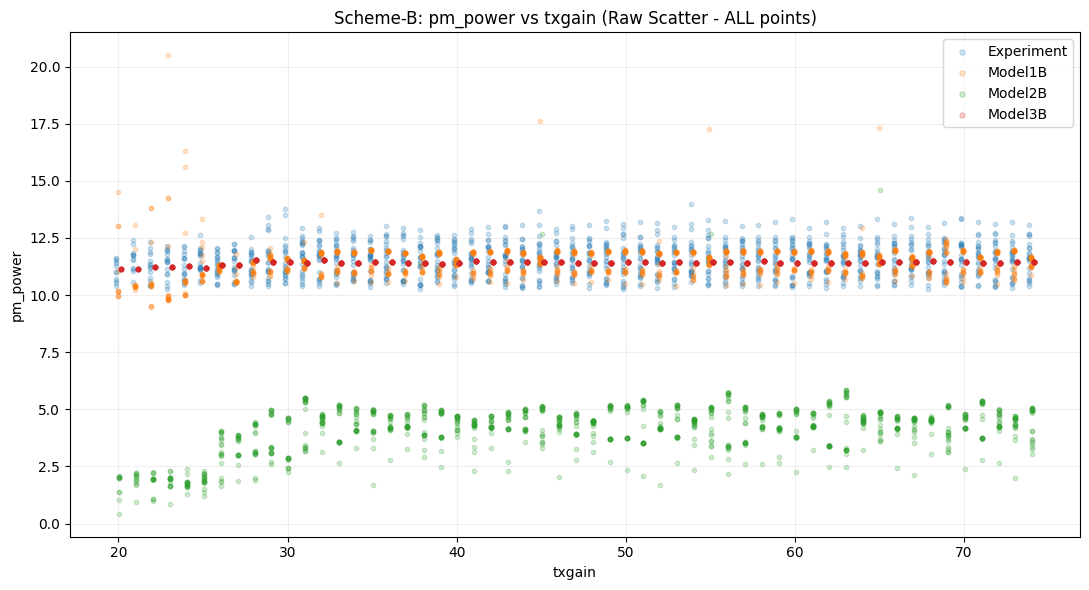

Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1B] MSE=0.6831 RMSE=0.8265 MAE=0.5125 MRE=4.42%
[Model2B] MSE=56.1783 RMSE=7.4952 MAE=7.4304 MRE=64.36%
[Model3B] MSE=0.5435 RMSE=0.7372 MAE=0.6141 MRE=5.27%


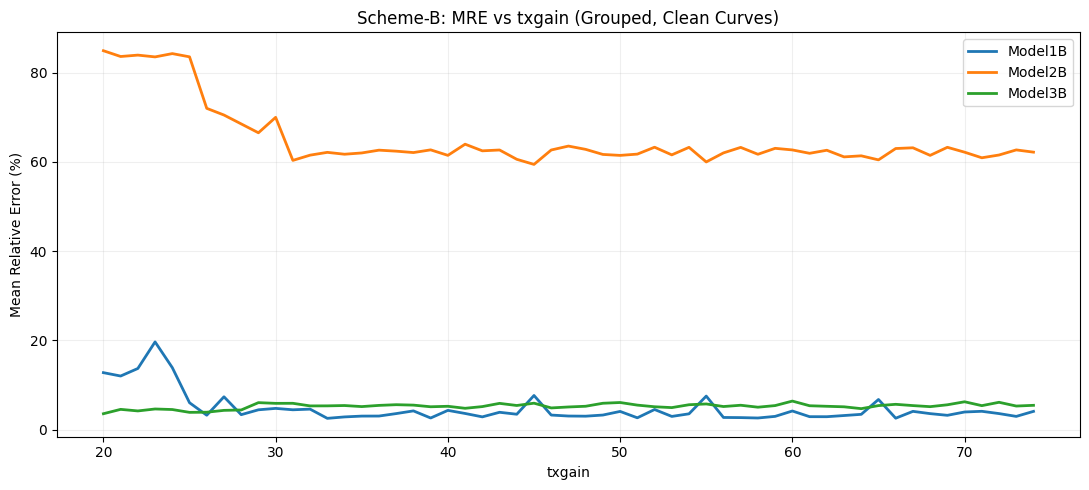

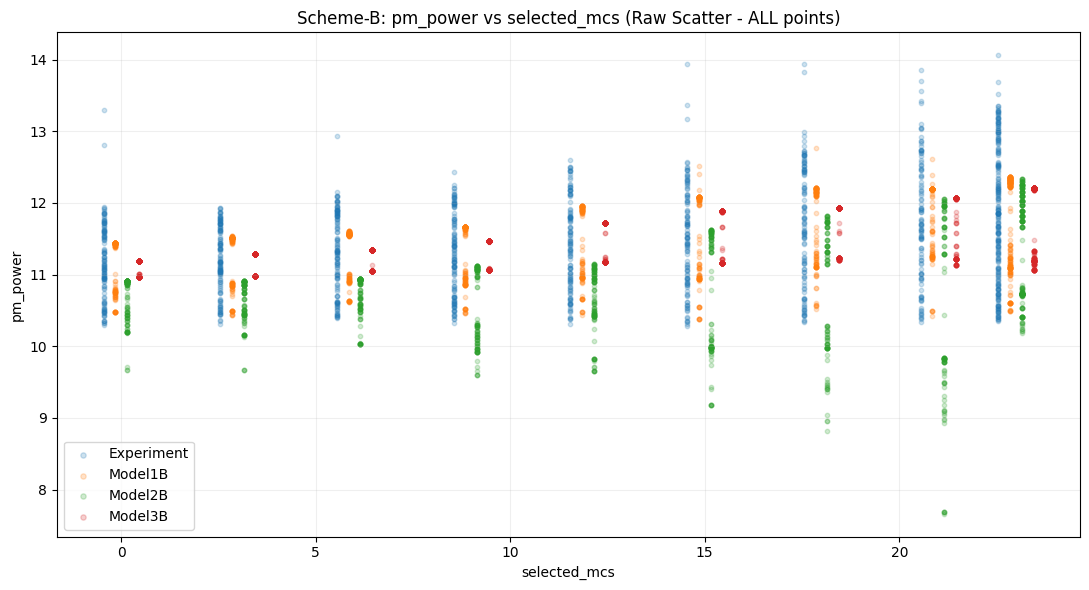

Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1B] MSE=0.2243 RMSE=0.4736 MAE=0.3611 MRE=3.10%
[Model2B] MSE=0.8320 RMSE=0.9121 MAE=0.7366 MRE=6.31%
[Model3B] MSE=0.2733 RMSE=0.5228 MAE=0.4237 MRE=3.65%


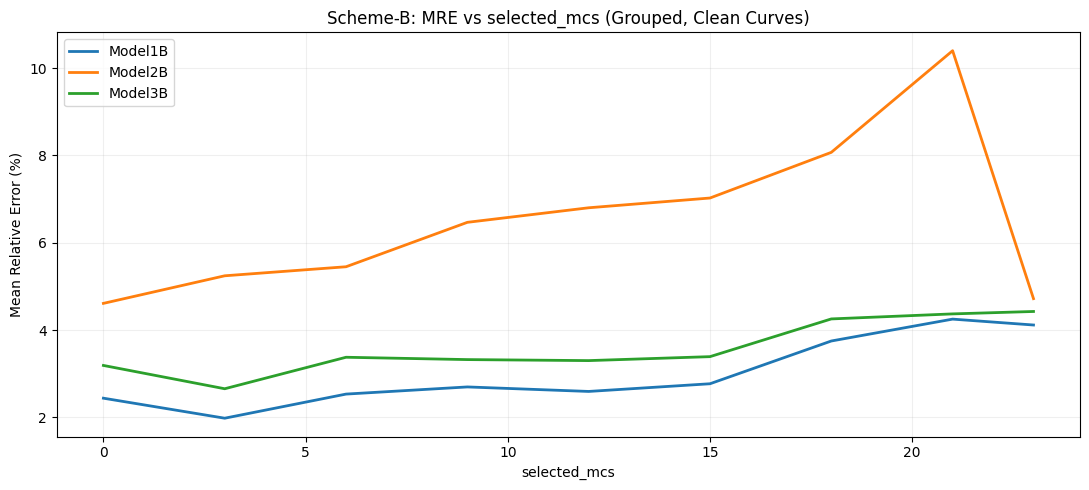

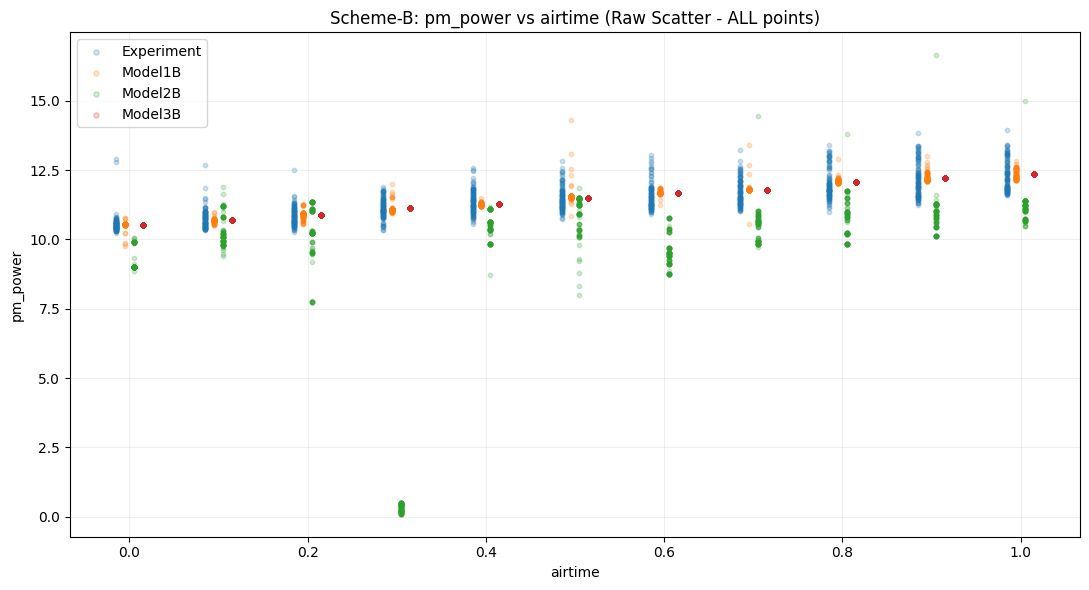

Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1B] MSE=0.2040 RMSE=0.4516 MAE=0.3429 MRE=2.95%
[Model2B] MSE=12.7129 RMSE=3.5655 MAE=2.0547 MRE=18.05%
[Model3B] MSE=0.2031 RMSE=0.4507 MAE=0.3465 MRE=2.97%


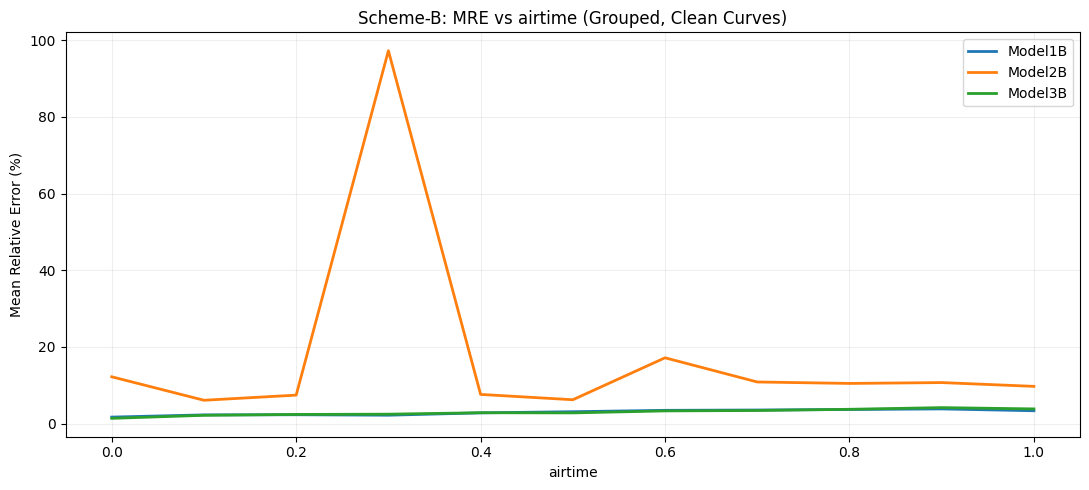

In [26]:
# ============================================================
# SCATTER (ALL POINTS) + CLEAN MRE CURVES — Scheme B
# Compare Model1B vs Model2B vs Model3B
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 0) Metrics
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 1) Helper: robustly fetch prediction key (兼容不同命名)
# ------------------------------------------------------------
def _pick_pred_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find prediction key in dict. Tried: {candidates}. Keys={list(d.keys())}")

def _as_float(x):
    try:
        return float(x)
    except Exception:
        # 有些 slice_value 可能是 numpy 类型 / 字符串
        return float(np.asarray(x).item())


# ------------------------------------------------------------
# 2) Build unified raw DF for scheme B (concatenate all slices)
# ------------------------------------------------------------
def build_raw_test_dataframe_B(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B):
    """
    Scheme B: each slice_value has its own trained model + its own test set.
    We concatenate ALL slice test points into one big df_plot for scatter/MRE curves.
    """

    # 兼容：有的人用 test_outputs_m1B[exp_name]，有的人用 test_outputs_m1B["m1"][exp_name]
    # 这里默认就是 test_outputs_m1B[exp_name]
    d_m1 = test_outputs_m1B[exp_name]
    d_m2 = test_outputs_m2B[exp_name]
    d_m3 = test_outputs_m3B[exp_name]

    def norm_map(d):
        mp = {}
        for k, v in d.items():
            mp[_as_float(k)] = v
        return mp

    m1 = norm_map(d_m1)
    m2 = norm_map(d_m2)
    m3 = norm_map(d_m3)

    common_keys = sorted(set(m1.keys()) & set(m2.keys()) & set(m3.keys()))
    if len(common_keys) == 0:
        raise ValueError(f"No common slice keys for exp={exp_name}. "
                         f"m1={len(m1)}, m2={len(m2)}, m3={len(m3)}")

    rows = []

    # slice_value 可能是 float，也可能是字符串
    for s in common_keys:

        d1 = m1[s]
        d2 = m2[s]
        d3 = m3[s]

        # 兼容预测字段命名
        k1 = _pick_pred_key(d1, ["y_pred_m1B", "y_pred_m1", "y_pred"])
        k2 = _pick_pred_key(d2, ["y_pred_m2B", "y_pred_m2", "y_pred"])
        k3 = _pick_pred_key(d3, ["y_pred_m3B", "y_pred_m3", "y_pred"])

        y_true = np.asarray(d1["y_true"]).reshape(-1)
        y_m1   = np.asarray(d1[k1]).reshape(-1)
        y_m2   = np.asarray(d2[k2]).reshape(-1)
        y_m3   = np.asarray(d3[k3]).reshape(-1)

        # 方案B：同一个 slice 内 x 恒等于 sval
        n = min(len(y_true), len(y_m1), len(y_m2), len(y_m3))
        if n == 0:
            continue
        
        y_true, y_m1, y_m2, y_m3 = y_true[:n], y_m1[:n], y_m2[:n], y_m3[:n]
        x = np.full(n, s, dtype=float)

        rows.append(pd.DataFrame({
            xcol: x,
            "y_true": y_true,
            "y_pred_m1": y_m1,
            "y_pred_m2": y_m2,
            "y_pred_m3": y_m3,
            "slice_value": s
        }))

    if len(rows) == 0:
        raise ValueError(f"Rows empty for exp={exp_name}. Possibly all slices had n==0 after alignment.")

    df_plot = pd.concat(rows, ignore_index=True)

    df_plot = df_plot.dropna(subset=[xcol, "y_true"]).copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter (ALL points) with horizontal offsets
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25,
    figsize=(11, 6)
):
    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # scheme B is usually discrete slices, but keep auto logic
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1B")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2B")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3B")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1B] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2B] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3B] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curves (grouped by x)
# ------------------------------------------------------------
def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g

def plot_mre_curves_clean(df_plot, xcol, title, min_count=1, figsize=(11, 5)):
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1B", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2B", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3B", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Run plots for gain / mcs / airtime (scheme B)
# ------------------------------------------------------------
# You MUST already have:
#   test_outputs_m1B, test_outputs_m2B, test_outputs_m3B
# in memory.

PLOT_CONFIG = {
    "gain":    ("txgain",        "Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)"),
}

import inspect
print(inspect.signature(build_raw_test_dataframe_B))


for exp_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe_B(
        exp_name=exp_name,
        xcol=xcol,
        test_outputs_m1B=test_outputs_m1_slices,
        test_outputs_m2B=test_outputs_m2_slices,
        test_outputs_m3B=test_outputs_m3B
    )

    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )
